# Question 2

## 问题回答

如果某个分类特征由 N 个数值特征组合，应使用分类特征还是涵盖更多信息的全部 N 个数值特征（N 较小） ？ 例如： 情况 1： 使用 A, B,
C 三个因子； 情况 2： 使用 A*(B>C) 因子（无需代码， 只需说明）

回答：我倾向于两种情况同时使用。合成一个新的特征，如果新合成的特征对分类有更强的解释性，例如，房子的特征
包含了L（长），W（宽）， 但是面积（S=W*L）可能是一个更好的特征，可以将L,W,S 这3个特征都加入模型进行训练。
或者，在训练之前，进行特征选择，保留有意义的特征。

## 模型部分

### 数据分析/清理

数据特征：
- 不均衡，TargetFeature = 1 只占1%左右
- 数据本身是time series，因此具有明显的auto correlation
- 有大量缺失数据
- 需要对inf/-inf进行特殊处理

参考：https://www.kaggle.com/shixw125/1st-place-lgb-model-public-0-506-private-0-511




In [1]:
import pandas as pd
import numpy as np
import os
import talib
from random import randrange
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

DATA_HOME = "E:\\tmp\\data\\interview"  # ！！！需要根据本地环境作修改
LABELS = ("Stock_1", "Stock_2", "Stock_3", "Stock_4", "Stock_5", "Stock_6", "Stock_7", 
                "Stock_8", "Stock_9", "Stock_10")
LOOK_BACK_PERIOD = [1,3,5,8,13,21,34]  # 回看时间长度
SAMPLE_INTERVAL = [3, 15]  # 数据采样间隔
ROLLING_WINDOW = 60    #计算滑动平均窗口长度

    # ----------------------- clean data and create features -------------------
def preprocess_data(label):
    file_path = os.path.join(DATA_HOME, f'{label}.csv')
    raw_data = pd.read_csv(file_path, index_col=0)
    # 处理NaN单元格
    raw_data.fillna(method='ffill', inplace=True)
    raw_data.fillna(method='bfill', inplace=True)
    raw_data.replace([np.inf, -np.inf], -1.0)   # not sure whether it is appropriate.
    # 构建额外feature
    features_for_training = dict()
    ######################## price #######################
    # mean price of feature 1,2,3,4 
    raw_data['PriceFeature_mean']=raw_data[['PriceFeature_1','PriceFeature_2',
                            'PriceFeature_3','PriceFeature_4']].mean(axis=1)  # 4者平均数
    # bband ***
    bb_up, bb_mid, bb_low = talib.BBANDS(raw_data['PriceFeature_mean'], timeperiod=ROLLING_WINDOW)
    raw_data['new_price_bb_from_up'] = raw_data['PriceFeature_mean']/bb_up - 1
    features_for_training['new_price_bb_from_up'] = 'float64'
    raw_data['new_price_bb_from_low'] = raw_data['PriceFeature_mean']/bb_low - 1
    features_for_training['new_price_bb_from_low'] = 'float64'
    # gap between the price_feature 1 to 4
    raw_data['new_price_gap_1m2'] = (raw_data['PriceFeature_1']-raw_data['PriceFeature_2'])/raw_data['PriceFeature_mean']
    raw_data['new_price_gap_1m3'] = (raw_data['PriceFeature_1']-raw_data['PriceFeature_3'])/raw_data['PriceFeature_mean']
    raw_data['new_price_gap_1m4'] = (raw_data['PriceFeature_1']-raw_data['PriceFeature_4'])/raw_data['PriceFeature_mean']
    raw_data['new_price_gap_2m3'] = (raw_data['PriceFeature_2']-raw_data['PriceFeature_3'])/raw_data['PriceFeature_mean']
    raw_data['new_price_gap_2m4'] = (raw_data['PriceFeature_2']-raw_data['PriceFeature_4'])/raw_data['PriceFeature_mean']
    raw_data['new_price_gap_3m4'] = (raw_data['PriceFeature_3']-raw_data['PriceFeature_4'])/raw_data['PriceFeature_mean']

    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_price_bb_from_up_t{i}'] = raw_data['new_price_bb_from_up'].shift(i)
        features_for_training[f'new_price_bb_from_up_t{i}'] = 'float64'
        raw_data[f'new_price_bb_from_low_t{i}'] = raw_data['new_price_bb_from_low'].shift(i)
        features_for_training[f'new_price_bb_from_low_t{i}'] = 'float64'

        raw_data[f'new_price_gap_1m2_t{i}'] = raw_data['new_price_gap_1m2'].shift(i)
        features_for_training[f'new_price_gap_1m2_t{i}'] = 'float64'
        raw_data[f'new_price_gap_1m3_t{i}'] = raw_data['new_price_gap_1m3'].shift(i)
        features_for_training[f'new_price_gap_1m3_t{i}'] = 'float64'
        raw_data[f'new_price_gap_1m4_t{i}'] = raw_data['new_price_gap_1m4'].shift(i)
        features_for_training[f'new_price_gap_1m4_t{i}'] = 'float64'
        raw_data[f'new_price_gap_2m3_t{i}'] = raw_data['new_price_gap_2m3'].shift(i)
        features_for_training[f'new_price_gap_2m3_t{i}'] = 'float64'
        raw_data[f'new_price_gap_2m4_t{i}'] = raw_data['new_price_gap_2m4'].shift(i)
        features_for_training[f'new_price_gap_2m4_t{i}'] = 'float64'
        raw_data[f'new_price_gap_3m4_t{i}'] = raw_data['new_price_gap_3m4'].shift(i)
        features_for_training[f'new_price_gap_3m4_t{i}'] = 'float64'

    # price momentum ***
    for i in LOOK_BACK_PERIOD:
        if i == 1:
            continue  # it's just one period return
        raw_data[f'new_price_mom_t{i}'] = raw_data['PriceFeature_mean'].pct_change(periods=i)
        features_for_training[f'new_price_mom_t{i}'] = 'float64'
    # log return ***
    raw_data['new_price_log_rt'] = np.log(raw_data['PriceFeature_mean']).diff()
    features_for_training['new_price_log_rt'] = 'float64'
    ## mean price change and look back ***
    ### log return look back ***
    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_log_return_t{i}'] = raw_data['new_price_log_rt'].shift(i)
        features_for_training[f'new_log_return_t{i}'] = 'float64'
    ### PriceFeature_5 look back ***
    features_for_training['PriceFeature_5'] = 'float64'
    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_price_5_t{i}'] = raw_data['PriceFeature_5'].shift(i)
        features_for_training[f'new_price_5_t{i}'] = 'float64'
    ### PriceFeature_6 look back ***
    features_for_training['PriceFeature_6'] = 'float64'
    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_price_6_t{i}'] = raw_data['PriceFeature_6'].shift(i)
        features_for_training[f'new_price_6_t{i}'] = 'float64'
    ### PriceFeature_7 look back ***
    features_for_training['PriceFeature_7'] = 'bool'
    for i in LOOK_BACK_PERIOD :
        raw_data[f'new_price_7_t{i}'] = raw_data['PriceFeature_7'].shift(i)
        features_for_training[f'new_price_7_t{i}'] = 'float64'
    ### PriceFeature_8 look back ***
    features_for_training['PriceFeature_8'] = 'bool'
    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_price_8_t{i}'] = raw_data['PriceFeature_8'].shift(i)
        features_for_training[f'new_price_8_t{i}'] = 'float64'

    ######################## volume #######################
    raw_data['new_vol_1_rolling_mean'] = raw_data['VolumeFeature_1'].rolling(ROLLING_WINDOW).mean() + 0.0001
    # *** vol norm + look back
    raw_data['new_vol_1_norm'] = raw_data['VolumeFeature_1']/raw_data['new_vol_1_rolling_mean'] 
    features_for_training['new_vol_1_norm'] = 'float64'
    ## vol Momentum ***
    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_vol_1_mom_t{i}'] = raw_data['new_vol_1_norm'].diff(periods=i)
        features_for_training[f'new_vol_1_mom_t{i}'] = 'float64'
        raw_data[f'new_vol_1_norm_t{i}'] = raw_data['new_vol_1_norm'].shift(i)
        features_for_training[f'new_vol_1_norm_t{i}'] = 'float64'

    features_for_training['VolumeFeature_2'] = 'bool'
    ## vol Momentum ***
    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_vol_2_t{i}'] = raw_data['VolumeFeature_2'].shift(i)
        features_for_training[f'new_vol_2_t{i}'] = 'bool'

    raw_data['new_vol_3_rolling_mean'] = raw_data['VolumeFeature_3'].rolling(ROLLING_WINDOW).mean() + 0.0001
    # *** vol norm + look back
    raw_data['new_vol_3_norm'] = raw_data['VolumeFeature_3']/raw_data['new_vol_3_rolling_mean'] 
    features_for_training['new_vol_3_norm'] = 'float64'
    ## vol Momentum ***
    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_vol_3_mom_t{i}'] = raw_data['new_vol_3_norm'].diff(periods=i)
        features_for_training[f'new_vol_3_mom_t{i}'] = 'float64'
        raw_data[f'new_vol_3_norm_t{i}'] = raw_data['new_vol_3_norm'].shift(i)
        features_for_training[f'new_vol_3_norm_t{i}'] = 'float64'

    raw_data['new_vol_4_rolling_mean'] = raw_data['VolumeFeature_4'].rolling(ROLLING_WINDOW).mean() + 0.0001
    raw_data['new_vol_4_norm'] = raw_data['VolumeFeature_4']/raw_data['new_vol_4_rolling_mean']
    features_for_training['new_vol_4_norm'] = 'float64'
    ## vol Momentum ***
    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_vol_4_mom_t{i}'] = raw_data['new_vol_4_norm'].diff(periods=i)
        features_for_training[f'new_vol_4_mom_t{i}'] = 'float64'
        raw_data[f'new_vol_4_norm_t{i}'] = raw_data['new_vol_4_norm'].shift(i)
        features_for_training[f'new_vol_4_norm_t{i}'] = 'float64'
        
    raw_data['new_vol_5_rolling_mean'] = raw_data['VolumeFeature_5'].rolling(ROLLING_WINDOW).mean() + 0.0001
    raw_data['new_vol_5_norm'] = raw_data['VolumeFeature_5']/raw_data['new_vol_5_rolling_mean']
    features_for_training['new_vol_5_norm'] = 'float64'
    ## vol Momentum ***
    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_vol_5_mom_t{i}'] = raw_data['new_vol_5_norm'].diff(periods=i)
        features_for_training[f'new_vol_5_mom_t{i}'] = 'float64'
        raw_data[f'new_vol_5_norm_t{i}'] = raw_data['new_vol_5_norm'].shift(i)
        features_for_training[f'new_vol_5_norm_t{i}'] = 'float64'

    raw_data['new_vol_6_rolling_mean'] = raw_data['VolumeFeature_6'].rolling(ROLLING_WINDOW).mean() + 0.0001
    raw_data['new_vol_6_norm'] = raw_data['VolumeFeature_6']/raw_data['new_vol_6_rolling_mean']
    features_for_training['new_vol_6_norm'] = 'float64'
    ## vol Momentum ***
    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_vol_6_mom_t{i}'] = raw_data['new_vol_6_norm'].diff(periods=i)
        features_for_training[f'new_vol_6_mom_t{i}'] = 'float64'
        raw_data[f'new_vol_6_norm_t{i}'] = raw_data['new_vol_6_norm'].shift(i)
        features_for_training[f'new_vol_6_norm_t{i}'] = 'float64'

    raw_data['new_vol_7_rolling_mean'] = raw_data['VolumeFeature_7'].rolling(ROLLING_WINDOW).mean() + 0.0001
    raw_data['new_vol_7_norm'] = raw_data['VolumeFeature_7']/raw_data['new_vol_7_rolling_mean']
    features_for_training['new_vol_7_norm'] = 'float64'
    ## vol Momentum ***
    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_vol_7_mom_t{i}'] = raw_data['new_vol_7_norm'].diff(periods=i)
        features_for_training[f'new_vol_7_mom_t{i}'] = 'float64'
        raw_data[f'new_vol_7_norm_t{i}'] = raw_data['new_vol_7_norm'].shift(i)
        features_for_training[f'new_vol_7_norm_t{i}'] = 'float64'

    raw_data['new_vol_8_rolling_mean'] = raw_data['VolumeFeature_8'].rolling(ROLLING_WINDOW).mean() + 0.0001
    raw_data['new_vol_8_norm'] = raw_data['VolumeFeature_8']/raw_data['new_vol_8_rolling_mean']
    features_for_training['new_vol_8_norm'] = 'float64'
    ## vol Momentum ***
    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_vol_8_mom_t{i}'] = raw_data['new_vol_8_norm'].diff(periods=i)
        features_for_training[f'new_vol_8_mom_t{i}'] = 'float64'
        raw_data[f'new_vol_8_norm_t{i}'] = raw_data['new_vol_8_norm'].shift(i)
        features_for_training[f'new_vol_8_norm_t{i}'] = 'float64'

    raw_data['new_vol_9_rolling_mean'] = raw_data['VolumeFeature_9'].rolling(ROLLING_WINDOW).mean() + 0.0001 # mean can be 0!
    raw_data['new_vol_9_norm'] = raw_data['VolumeFeature_9']/raw_data['new_vol_9_rolling_mean']
    features_for_training['new_vol_9_norm'] = 'float64'
    ## vol Momentum ***
    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_vol_9_mom_t{i}'] = raw_data['new_vol_9_norm'].diff(periods=i)
        features_for_training[f'new_vol_9_mom_t{i}'] = 'float64'
        raw_data[f'new_vol_9_norm_t{i}'] = raw_data['new_vol_9_norm'].shift(i)
        features_for_training[f'new_vol_9_norm_t{i}'] = 'float64'

    raw_data['new_vol_10_rolling_mean'] = raw_data['VolumeFeature_10'].rolling(ROLLING_WINDOW).mean() + 0.0001
    raw_data['new_vol_10_norm'] = raw_data['VolumeFeature_10']/raw_data['new_vol_10_rolling_mean']
    features_for_training['new_vol_10_norm'] = 'float64'
    ## vol Momentum ***
    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_vol_10_mom_t{i}'] = raw_data['new_vol_10_norm'].diff(periods=i)
        features_for_training[f'new_vol_10_mom_t{i}'] = 'float64'
        raw_data[f'new_vol_10_norm_t{i}'] = raw_data['new_vol_10_norm'].shift(i)
        features_for_training[f'new_vol_10_norm_t{i}'] = 'float64'

    raw_data['new_vol_11_rolling_mean'] = raw_data['VolumeFeature_11'].rolling(ROLLING_WINDOW).mean() + 0.0001
    raw_data['new_vol_11_norm'] = raw_data['VolumeFeature_11']/raw_data['new_vol_11_rolling_mean']
    features_for_training['new_vol_11_norm'] = 'float64'
    ## vol Momentum ***
    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_vol_11_mom_t{i}'] = raw_data['new_vol_11_norm'].diff(periods=i)
        features_for_training[f'new_vol_11_mom_t{i}'] = 'float64'
        raw_data[f'new_vol_11_norm_t{i}'] = raw_data['new_vol_11_norm'].shift(i)
        features_for_training[f'new_vol_11_norm_t{i}'] = 'float64'

    raw_data['new_vol_12_rolling_mean'] = raw_data['VolumeFeature_12'].rolling(ROLLING_WINDOW).mean() + 0.0001
    raw_data['new_vol_12_norm'] = raw_data['VolumeFeature_12']/raw_data['new_vol_12_rolling_mean']
    features_for_training['new_vol_12_norm'] = 'float64'
    ## vol Momentum ***
    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_vol_12_mom_t{i}'] = raw_data['new_vol_12_norm'].diff(periods=i)
        features_for_training[f'new_vol_12_mom_t{i}'] = 'float64'
        raw_data[f'new_vol_12_norm_t{i}'] = raw_data['new_vol_12_norm'].shift(i)
        features_for_training[f'new_vol_12_norm_t{i}'] = 'float64'

    features_for_training['VolumeFeature_13'] = 'float64'
    ## vol Momentum ***
    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_vol_13_t{i}'] = raw_data['VolumeFeature_13'].shift(i)
        features_for_training[f'new_vol_13_t{i}'] = 'float64'        

    ####################### Tape #######################
    features_for_training['TapeFeature_1'] = 'bool'
    features_for_training['TapeFeature_2'] = 'float64'
    features_for_training['TapeFeature_4'] = 'float64'
    features_for_training['TapeFeature_5'] = 'bool'
    features_for_training['TapeFeature_6'] = 'float64'
    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_tape_1_t{i}'] = raw_data['TapeFeature_1'].shift(i)
        features_for_training[f'new_tape_1_t{i}'] = 'bool'
        raw_data[f'new_tape_2_t{i}'] = raw_data['TapeFeature_2'].shift(i)
        features_for_training[f'new_tape_2_t{i}'] = 'float64'
        raw_data[f'new_tape_4_t{i}'] = raw_data['TapeFeature_4'].shift(i)
        features_for_training[f'new_tape_4_t{i}'] = 'float64'
        raw_data[f'new_tape_5_t{i}'] = raw_data['TapeFeature_5'].shift(i)
        features_for_training[f'new_tape_5_t{i}'] = 'bool'
        raw_data[f'new_tape_6_t{i}'] = raw_data['TapeFeature_6'].shift(i)
        features_for_training[f'new_tape_6_t{i}'] = 'float64'
    
    raw_data['new_tape_3_rolloing_abs_mean'] = raw_data['TapeFeature_3'].abs().rolling(ROLLING_WINDOW).mean() + 0.0001
    # normalize ***
    raw_data['new_tape_3_abs_norm'] = raw_data['TapeFeature_3']/raw_data['new_tape_3_rolloing_abs_mean'] 
    features_for_training['new_tape_3_abs_norm'] = 'float64'
    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_tape_3_abs_norm_t{i}'] = raw_data['new_tape_3_abs_norm'].shift(i)
        features_for_training[f'new_tape_3_abs_norm_t{i}'] = 'float64'

    raw_data['new_tape_3_rolloing_mean'] = raw_data['TapeFeature_3'].rolling(ROLLING_WINDOW).mean() + 0.0001
    # normalize ***
    raw_data['new_tape_3_norm'] = raw_data['TapeFeature_3']/raw_data['new_tape_3_rolloing_mean'] 
    features_for_training['new_tape_3_norm'] = 'float64'
    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_tape_3_norm_t{i}'] = raw_data['new_tape_3_abs_norm'].shift(i)
        features_for_training[f'new_tape_3_norm_t{i}'] = 'float64'    

    ####################### Transaction #######################
    # look back
    features_for_training['TransactionFeature_1'] = 'bool'
    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_trans_1_t{i}'] = raw_data['TransactionFeature_1'].shift(i)
        features_for_training[f'new_trans_1_t{i}'] = 'bool'

    ####################### order #######################
    # normalize 
    raw_data['new_order_1_rolloing_mean'] = raw_data['OrderFeature_1'].rolling(ROLLING_WINDOW).mean() + 0.0001
    raw_data['new_order_1_norm'] = raw_data['OrderFeature_1']/raw_data['new_order_1_rolloing_mean'] 
    features_for_training['new_order_1_norm'] = 'float64' 
    features_for_training['OrderFeature_2'] = 'float64' 
    features_for_training['OrderFeature_3'] = 'float64' 
    features_for_training['OrderFeature_4'] = 'float64' 
    for i in LOOK_BACK_PERIOD:
        raw_data[f'new_order_1_norm_t{i}'] = raw_data['new_order_1_norm'].shift(i)
        features_for_training[f'new_order_1_norm_t{i}'] = 'float64'
        raw_data[f'new_order_2_t{i}'] = raw_data['OrderFeature_2'].shift(i)
        features_for_training[f'new_order_2_t{i}'] = 'float64'
        raw_data[f'new_order_3_t{i}'] = raw_data['OrderFeature_3'].shift(i)
        features_for_training[f'new_order_3_t{i}'] = 'float64'
        raw_data[f'new_order_4_t{i}'] = raw_data['OrderFeature_4'].shift(i)
        features_for_training[f'new_order_4_t{i}'] = 'float64'
    return raw_data, features_for_training

### 数据采样

由于time series 数据具有auto correlation的特性，那么，相邻的数据具有很高的相关性。因此，如果直接使用这些数据，那么这些数据
很明显就不是IID，这样训练出来的模型效果会受到影响。

这里使用一种简单的方法，就是随机间隔采样，用这种方式对负样本进行采样，同时完整保留正样本。因为，正样本实在太少了，因此受auto correlation
的影响可以忽略。

强调：这里的目的不是欠采样，而是希望训练的数据更加符合IID以提高训练质量。

In [2]:
def sampling(raw_data):
    df = raw_data.dropna()
    
    first_index = df.iloc[[0,-1]].index[0]
    last_index = df.iloc[[0,-1]].index[1]
    sample_ids = set()
    # keep all TargetFeature = 1
    for i in df[df['TargetFeature']==1].index:
        sample_ids.add(i)
        # also get the neighbor
        if i - 1 >= first_index:
            sample_ids.add(i - 1)
        if i + 1 <= last_index:
            sample_ids.add(i + 1)
    row_index = first_index - SAMPLE_INTERVAL[0]  # in accordance with randrange(3, 15)
    while True:
        row_index += randrange(SAMPLE_INTERVAL[0], SAMPLE_INTERVAL[1])  # uniform distribution between 3~15
        if row_index <= last_index:
            sample_ids.add(row_index)
        else:
            break
    sample_ids = sorted(sample_ids)
    return df.reindex(sample_ids)


### 特征选择

这里通过两种方式进行特征筛选，获取两者的并集。两者方式分别是DecisionTreeClassifier以及RandomForestClassifier

In [3]:
# 将stock1~10的数据汇总
total_data = pd.DataFrame()
for label in LABELS:
    print(f'processing {label} file ......')
    data, features = preprocess_data(label)
    sample_data = sampling(data)
    sample_data['label'] = label  # add a new column/feature
    total_data = total_data.append(sample_data.copy())    
total_data.replace([np.inf, -np.inf], -1.0, inplace=True)
total_data.dropna()
print('正负样本分布：')
print(total_data['TargetFeature'].value_counts())


processing Stock_1 file ......
processing Stock_2 file ......
processing Stock_3 file ......
processing Stock_4 file ......
processing Stock_5 file ......
processing Stock_6 file ......
processing Stock_7 file ......
processing Stock_8 file ......
processing Stock_9 file ......
processing Stock_10 file ......
正负样本分布：
0    69423
1     5717
Name: TargetFeature, dtype: int64


In [4]:

# use DecisionTreeClassifier
df_feature_sel = total_data[total_data["label"] == 'Stock_1']
X = df_feature_sel[list(features.keys())]
# X = X.replace([np.inf, -np.inf], -1.0)   # ???How to handle inf??? # !!! to be deleted
y = df_feature_sel['TargetFeature']
clf = DecisionTreeClassifier(class_weight='balanced')  # consider the imbalance training data
trans = SelectFromModel(clf, threshold='0.8*mean')  #, threshold='0.1*mean'
X_trans = trans.fit_transform(X, y)
print("For DecisionTreeClassifier, We started with {0} features but retained only {1} of them!".format(X.shape[1], X_trans.shape[1]))
useful_featrues_1 = X.columns[trans.get_support()].values

# use RandomForestClassifier
le = LabelEncoder()
# X = total_data.replace([np.inf, -np.inf], -1.0) # !!! to be deleted
total_data["label_encode"] = le.fit_transform(total_data["label"].values)
feature_list = list(features.keys())
feature_list.append('label_encode')  # Stock_1 ... 10 is a feature.
X = total_data[feature_list]
y = total_data['TargetFeature']
clf = RandomForestClassifier(n_estimators=500, random_state=0, class_weight='balanced')
trans = SelectFromModel(clf, threshold='median') 
X_trans = trans.fit_transform(X, y)
print("For RandomForestClassifier We started with {0} features but retained only {1} of them!".format(X.shape[1], X_trans.shape[1]))
useful_featrues_2 = X.columns[trans.get_support()].values
# merge the features 
features_for_train = set(useful_featrues_1) | set(useful_featrues_2)
features_for_train.add('label_encode')
features_for_train = list(features_for_train)
print('the selected feature:::')
print(features_for_train)


For DecisionTreeClassifier, We started with 381 features but retained only 51 of them!
For RandomForestClassifier We started with 382 features but retained only 191 of them!
the selected feature:::
['new_vol_13_t8', 'new_price_mom_t3', 'new_tape_4_t1', 'new_order_2_t5', 'new_order_2_t8', 'new_vol_12_norm_t13', 'new_vol_11_mom_t5', 'new_vol_9_mom_t1', 'new_vol_11_norm_t21', 'new_vol_1_norm_t8', 'new_vol_1_mom_t13', 'new_tape_3_norm', 'new_vol_10_mom_t21', 'new_price_gap_1m2_t5', 'new_vol_9_mom_t34', 'new_vol_6_mom_t3', 'new_vol_9_mom_t13', 'new_price_gap_1m3_t8', 'new_vol_10_norm_t1', 'new_tape_3_norm_t3', 'new_vol_5_mom_t5', 'new_price_gap_1m4_t13', 'new_vol_11_mom_t1', 'new_vol_12_mom_t8', 'new_order_1_norm_t1', 'new_price_mom_t5', 'new_order_1_norm_t3', 'new_vol_10_norm_t3', 'new_vol_3_norm_t3', 'new_vol_10_mom_t34', 'new_tape_2_t3', 'new_price_gap_1m3_t21', 'new_vol_5_norm_t21', 'new_tape_2_t21', 'new_vol_13_t5', 'new_price_mom_t8', 'new_vol_1_mom_t21', 'new_price_gap_1m3_t13', 'new

### 训练模型

这里使用RandomForestClassifier， 需要注意，由于训练数据是非均衡的，因此需要设置class_weight的参数以适应这种场景。

#### 做简单的优化

通过使用GridSearchCV，对少部分超参数进行调优

In [10]:
X_train, X_validate, y_train, y_validate = train_test_split(total_data[features_for_train], 
            y, test_size=0.3, shuffle=True) # 其实这里一个比较好的方法是将shuffle=False，分别
                                            # 从10个文件里面进行split
parameters = {'max_depth':[13,14],
              'n_estimators':[600],
              'class_weight':[{0:1, 1:3}, {0:0.17, 1:0.83}, 'balanced'],
              'random_state':[42]}   # 'criterion':['gini', 'entropy'],

              #'class_weight':[{0:0.17, 1:0.83}, {0:0.12, 1:0.88}, {0:0.1, 1:0.9}, {0:0.08, 1:0.92}, 'balanced'],

def perform_grid_search(X_data, y_data):
    # rf = RandomForestClassifier(class_weight='balanced', criterion='entropy')
    rf = RandomForestClassifier(criterion='entropy')
    # clf = GridSearchCV(rf, parameters, cv=5, scoring='roc_auc', n_jobs=3)  
    clf = GridSearchCV(rf, parameters, cv=5, scoring='f1_weighted', n_jobs=3) 
    clf.fit(X_data, y_data)
    print(clf.cv_results_['mean_test_score'])
    # return clf.best_params_['n_estimators'], clf.best_params_['max_depth']
    return clf

grid_results = perform_grid_search(X_train, y_train)
n_estimators = grid_results.best_params_['n_estimators']
max_depth = grid_results.best_params_['max_depth']
class_weight = grid_results.best_params_['class_weight']
# criterion = grid_results.best_params_['criterion']
# n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimators, max_depth, c_random_state, class_weight)

[0.95362378 0.95253519 0.95428365 0.95365049 0.95274651 0.95371042]
600 13 42 {0: 0.17, 1: 0.83}


将优化后的超参输入到RandomForestClassifier以开始最终训练

In [6]:
# Random Forest Model with optimized hyper-parameter
rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators,
                            criterion='entropy', random_state=c_random_state, class_weight=class_weight) # 'balanced'
rf.fit(X_train, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight={0: 0.17, 1: 0.83},
            criterion='entropy', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=900, n_jobs=None, oob_score=False,
            random_state=42, verbose=0, warm_start=False)

### 模型评估

#### In Sample:

precision    recall  f1-score   support

           0       1.00      0.98      0.99     48597
           1       0.81      1.00      0.89      4001

   micro avg       0.98      0.98      0.98     52598
   macro avg       0.90      0.99      0.94     52598
weighted avg       0.99      0.98      0.98     52598

Confusion Matrix
[[47633   964]
 [    0  4001]]

Accuracy
0.9816723069318225


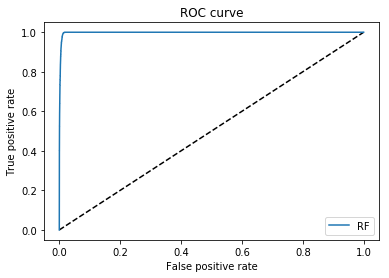

In [7]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### Out of Sample

precision    recall  f1-score   support

           0       0.98      0.97      0.97     20826
           1       0.66      0.77      0.71      1716

   micro avg       0.95      0.95      0.95     22542
   macro avg       0.82      0.87      0.84     22542
weighted avg       0.96      0.95      0.95     22542

Confusion Matrix
[[20133   693]
 [  394  1322]]

Accuracy
0.9517789016058912


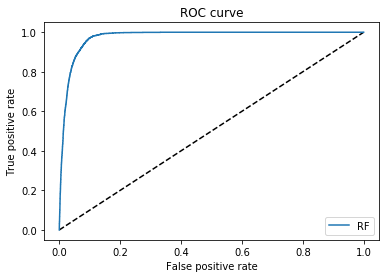

In [8]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_validate)[:, 1]
y_pred = rf.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

#### 特征重要性排序


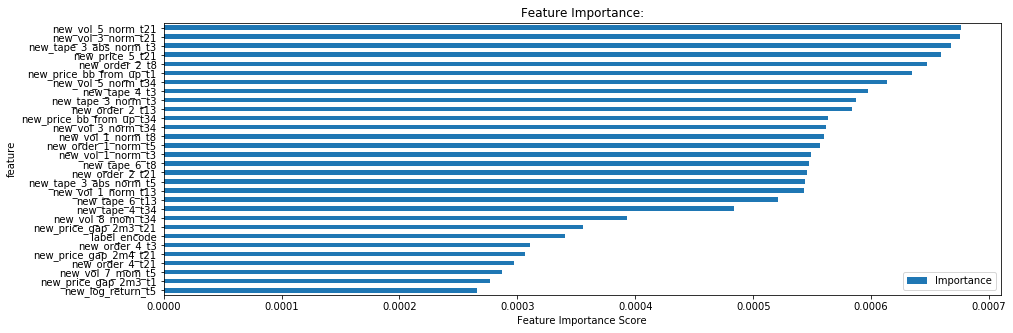

In [40]:
title = 'Feature Importance:'
figsize = (15, 5)

feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})    
feat_imp['feature'] = X_train.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.iloc[0:30].plot.barh(title=title, figsize=figsize) # top 30 features
plt.xlabel('Feature Importance Score')
plt.show()

### 结论

通过数据清洗，特征工程，到最后确定入围的特征，再通过RandomForestClassifier进行训练。从out of sample的结果来看还是相对满意的，正样本的precision为0.58。而正负样本的recall都比较高（时间原因，没有对class_weight做优化，precision应该是可以再提高的）

在防止过拟合方面，由于使用的是RandomForest分类器，因此，需要对n_estimators， max_features，max_depth，min_samples_leaf等这些参数进行调试，并通过cross validaiton的方式来验证。

惩罚项方面，通过 class_weight 对正样本分错进行加重惩罚。

